>Borrowed with love from Serge Retkowsky at https://github.com/retkowsky/Azure-OpenAI-demos

# Processing and narrating a video with GPT-4 visual capabilities and the TTS API

This notebook demonstrates how to use GPT-4 visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API

**This notebook has been modified to work with Azure OpenAI's vision-preview model.**

In [29]:
#%pip install openai requests opencv-python

In [2]:
# Assumes you have an .env file in the current directory
# It should look like this:
#
# ENDPOINT=https://YOUR_OPENAI_INSTANCE_NAME.openai.azure.com/
# KEY=a6dxxxxxxxxxxxxxxe3f
# DEPLOYMENT=gpt-4-vision

%reload_ext dotenv
%dotenv

In [27]:
from IPython.display import display, Image, Audio, Video

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import AzureOpenAI
import os
import requests
from IPython.display import Markdown as md

client = AzureOpenAI(
    api_key=os.getenv("KEY"),  
    api_version="2024-02-01",
    azure_endpoint = os.getenv("ENDPOINT")
    )

DEPLOYMENT_NAME = os.getenv("DEPLOYMENT")
VIDEO_SOURCE='honeybadger.mp4'

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a video.
[YouTube](https://www.youtube.com/watch?v=kQ_7GtE529M)


In [28]:
video = cv2.VideoCapture(VIDEO_SOURCE)

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

795 frames read.


Display frames to make sure we've read them in correctly:


## Meet the honeybadger

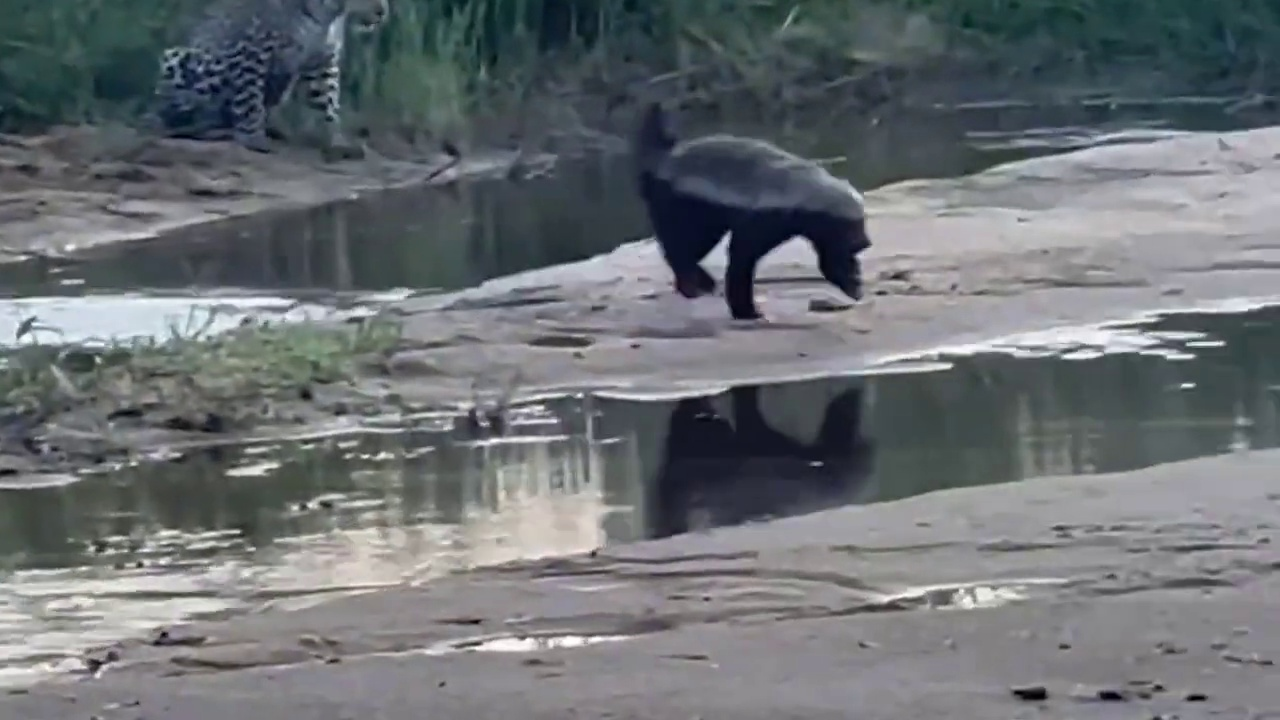

In [29]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [30]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            """These are frames from a video that I want to upload. Generate a gripping
            story about the honeybadger and its fight, in romanian language. You know very good
            romanian, don't hesitate to use fancy words.
            I will use this as voiceover for the original video.
            Story must be under 26 seconds when read aloud. Only output the story.""",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::85]),
        ],
    },
]

params = {
    "model": DEPLOYMENT_NAME,
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
md('### ' + result.choices[0].message.content)

## În savana africană, întâlnim ratonul miere, o creatură neînfricată, și confruntarea sa epică cu un leopard întunecat. În ciuda diferenței de mărime, ratonul miere rămâne neclintit, apărându-și teritoriul cu o furie nețărmurită. Lupta este scurtă și intensă, însă ratonul miere demonstrează că nu mărimea contează și că, chiar și în fața unui prădător atât de temut, curajul și determinarea pot învinge. Un adevărat David și Goliat al naturii sălbatice.

Now we can pass the voiceover script to the TTS API where it will generate an mp3 of the voiceover:


In [31]:
# Using Azure OpenAI TTS models - in Public Preview
response = requests.post(
    "https://swecentralgpt4vision.openai.azure.com/openai/deployments/ttshd/audio/speech?api-version=2024-02-15-preview",
    headers={
        "api-key": os.environ['KEY']
    },
    json={
        "model": "tts-1-hd",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk

with open("narration.mp3", "wb") as binary_file:
    binary_file.write(audio)

Audio(audio)

## 3. Dub the original video with our voiceover


In [32]:
FINAL_VIDEO = "final-honeybadger-ro.mp4"

In [33]:
!ffmpeg -loglevel error -stats \
    -i {VIDEO_SOURCE} -i narration.mp3 \
    -c:v copy -map 0:v:0 -map 1:a:0 -y {FINAL_VIDEO} && echo '-- ffmpeg done --'

frame=  795 fps=0.0 q=-1.0 Lsize=    7898kB time=00:00:30.37 bitrate=2129.7kbits/s speed= 109x    
-- ffmpeg done --


In [34]:
Video(FINAL_VIDEO, width=640, height=360)